# Import the dependencies

In [1]:
import os
import sys
from pathlib import Path
import pickle
import shutil
from typing import Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

sys.path.append(str(Path.cwd().parent))

from utils import util
from utils import seismic_hazard_analysis as sha
from qcore import nhm
from qcore import coordinates as coords
from empirical.util.classdef import TectType, GMM


from concurrent.futures import ThreadPoolExecutor

/mnt/hypo_data/mab419/mab419_cybershake_investigation/utils/seismic_hazard_analysis/site_source.py:960: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  scenario_section_ids[i],


# Path and directory works

In [2]:
root_path = os.getcwd()

data_version = "combined_v20p6_v24p8_v20p9_v24p9"
sim_dir = f"/mnt/hypo_data/mab419/Cybershake_Data/{data_version}"  # dpath to simulation data
sim_pickle_dir = f"/mnt/hypo_data/mab419/Cybershake_Data_Pickle/{data_version}"  # dpath to hazard calculation data
emp_dir = f"/mnt/hypo_data/mab419/Empirical_Data/{data_version}"  # dpath to emirical calculation data
base_dir = "/mnt/hypo_data/mab419/mab419_cybershake_investigation/base_data"  # dpath to dirctory of base data

# File names of the stations data
station_files = {
    "stations_ll": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.ll",
    "stations_vs30": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.vs30",
    "stations_z": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.z",
}

fault_erf_ffp = os.path.join(base_dir, "NZ_FLTmodel_2010.txt") #dpath to NZ fault model
background_ffp = os.path.join(
    base_dir, "NZBCK2015_Chch50yearsAftershock_OpenSHA_modType4.txt") #dpath to background seismicity
ds_erf_ffp = os.path.join(base_dir, "NZ_DSmodel_2015.txt")  # dpath to DS erf

# Plotting Major Setting

In [3]:
plt.rcParams.update(
    {
        "font.size": 7,  # General font size
        "font.family": "serif",  # Font family (e.g., serif, sans-serif, monospace)
        "axes.titlesize": 8,  # Title font size
        "axes.labelsize": 8,  # Axis label font size
        "xtick.labelsize": 7,  # X-axis tick font size
        "ytick.labelsize": 7,  # Y-axis tick font size
        "legend.fontsize": 7,  # Legend font size
    }
)

color_dic = {"csds_color": "#4682B4", "cs_color": "#4682B4", "ds_color": "#000000"}

linestyle_dic = {"csds_linestyle": "-", "cs_linestyle": "--", "ds_linestyle": ":"}

linewidth_dic = {"csds_linewidth": 1, "cs_linewidth": 1, "ds_linewidth": 1}

# Loading Stations Data

In [4]:
# get all stations data
stations_df = util.get_station_data(
    os.path.join(base_dir, station_files["stations_ll"]),
    os.path.join(base_dir, station_files["stations_vs30"]),
    os.path.join(base_dir, station_files["stations_z"]),
)

# Loading ERF

In [5]:
flt_erf_df = nhm.load_nhm_df(fault_erf_ffp)
flt_erf = nhm.load_nhm(fault_erf_ffp)
# faults = {
#     cur_name: sha.nshm_2010.get_fault_objects(cur_fault)
#     for cur_name, cur_fault in flt_erf.items()
# }

# Loading Background Seimicity

In [6]:

ds_erf_df = pd.read_csv(ds_erf_ffp, index_col="rupture_name")

# Loading Simulation Data

## Load Simulation Data from Pickle

In [7]:
file_name = "Cybershake_fault_im_data.pkl"
file_path = os.path.join(sim_pickle_dir, file_name)
with open(file_path, "rb") as file:
    fault_im_data = pickle.load(file)

print("Dictionary loaded successfully")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/hypo_data/mab419/Cybershake_Data_Pickle/combined_v20p6_v24p8_v20p9_v24p9/Cybershake_fault_im_data.pkl'

## Load Simulation Data from CSV Files

### Load Data from CSV Files

In [7]:
fault_im_data = sha.nshm_2010.load_sim_im_data(Path(sim_dir)) # Estimated time: 32min

100%|██████████| 486/486 [07:00<00:00,  1.15it/s]


### Write Pickle File

In [8]:
# Check if the directory exists
if Path(sim_pickle_dir).exists():
    prompt = input(
        f"The following path already exists! Do you want to delete and renew (1) or terminate (2)? \n{sim_pickle_dir}\n"
    )
    if prompt == 1:
        # Remove the folder
        shutil.rmtree(sim_pickle_dir)
        print(f"Deleted and renewed the path: \n{sim_pickle_dir}")
        os.makedirs(sim_pickle_dir, exist_ok=False)
    elif prompt == 2:
        print("Terminating the process.")
        exit()
    else:
        print("Invalid input. Terminating the process.")
        exit()

else:
    os.makedirs(sim_pickle_dir, exist_ok=False)
    print(f"Created the path: \n{sim_pickle_dir}")

file_name = "Cybershake_fault_im_data.pkl"
file_path = os.path.join(sim_pickle_dir, file_name)
with open(file_path, "wb") as file:
    pickle.dump(fault_im_data, file)

print(f"Dictionary saved to {file_path}")

Created the path: 
/mnt/hypo_data/mab419/Cybershake_Data_Pickle/combined_v20p6_v24p8_v20p9_v24p9
Dictionary saved to /mnt/hypo_data/mab419/Cybershake_Data_Pickle/combined_v20p6_v24p8_v20p9_v24p9/Cybershake_fault_im_data.pkl


# Creating Hazard Outputs

## Hazard Curve of Specific IM(s) in Specific Station(s)

### Define Stations and IMs

In [9]:
# Define Stations and IMs

stations = ["PIPS", "WTES"]
ims= ["pSA_1.0", "pSA_3.0", "pSA_5.0"]

### Computing CS Hazard

In [10]:
# Define function for calculating multi site cybershake hazard

def compute_sim_hazard_multisite(
    fault_im_dict: dict[str, xr.DataArray],
    stations: Sequence[str],
    ims: Sequence[str] = None,
):
    """
    Computes the simulation-based seismic hazard
    for a multiple sites.

    Parameters
    ----------
    stations: Sequence of str
        The stations for which to compute the hazard
    ims: Sequence of str
        The IMs for which to compute the hazard
    im_levels: dict
        The IM levels for each IM
    fault_im_dict: dict
        The IM data for each fault as a DataArray
        [output of the seismic_hazard_analysis.nshm_2010.load_sim_im_data function]
    site_im_df: pd.DataFrame
        The IM data for the site.
        Index has to be a MultIndex [fault, realisation]

    Returns
    -------
    hazard_results: dict
        The hazard curve for each IM
    """
    im_hazard_dic = {
        im: pd.DataFrame(
            index=stations,
            columns=sha.utils.get_im_levels(im).tolist(),
        )
        for im in ims
    }

    for st in stations:
        site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_dict, st)
        im_hazard = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df, ims)

        for im, value in im_hazard.items():
            valid_columns = im_hazard_dic[im].columns.intersection(value.index)
            im_hazard_dic[im].loc[st, valid_columns] = value[valid_columns].values

    return im_hazard_dic

In [11]:
cs_im_hz_dic = compute_sim_hazard_multisite(
    fault_im_dict=fault_im_data,
    stations=stations,
    ims=ims,
)

### Compute DS Hazard

In [12]:
# Define function for calculating multi site distributed seimicity hazard


def compute_ds_hazard_multisite(
    background_ffp,
    stations_df,
    GMM_MAPPING,
    ds_erf_df,
    stations: Sequence[str],
    site_vs30: float = None,
    site_z1p0: float = None,
    ims: Sequence[str] = None,
):
    """
    Computes the simulation-based seismic hazard
    for a multiple sites.

    Parameters
    ----------
    stations: Sequence of str
        The stations for which to compute the hazard
    ims: Sequence of str
        The IMs for which to compute the hazard
    im_levels: dict
        The IM levels for each IM
    fault_im_dict: dict
        The IM data for each fault as a DataArray
        [output of the seismic_hazard_analysis.nshm_2010.load_sim_im_data function]
    site_im_df: pd.DataFrame
        The IM data for the site.
        Index has to be a MultIndex [fault, realisation]

    Returns
    -------
    hazard_results: dict
        The hazard curve for each IM
    """
    im_hazard_dic = {
        im: pd.DataFrame(
            index=stations,
            columns=sha.utils.get_im_levels(im).tolist(),
        )
        for im in ims
    }

    if site_vs30 is None:
        site_vs30_list = stations_df[stations_df["station_name"].isin(stations)][
            "vs30"
        ].tolist()
    else:
        site_vs30_list = [site_vs30] * len(stations)

    if site_z1p0 is None:
        site_z1p0_list = stations_df[stations_df["station_name"].isin(stations)][
            "Z_1.0(km)"
        ].tolist()
    else:
        site_z1p0_list = [site_z1p0] * len(stations)

    site_coords_list = [
        np.array(
            [
                [
                    stations_df[stations_df["station_name"] == st]["lat"].values[0],
                    stations_df[stations_df["station_name"] == st]["long"].values[0],
                    0,
                ]
            ]
        )
        for st in stations
    ]

    PERIODS = [float(im.split("_")[1]) for im in ims]

    site_nztm_list = [
        coords.wgs_depth_to_nztm(site_coords)[0, [1, 0, 2]]
        for site_coords in site_coords_list
    ]

    for i, st in enumerate(stations):

        ds_rupture_df = sha.nshm_2010.get_ds_rupture_df(
            background_ffp,
            site_nztm_list[i],
            float(site_vs30_list[i]),
            float(site_z1p0_list[i]),
        )

        ds_gm_params_df = sha.nshm_2010.get_emp_gm_params(
            ds_rupture_df, GMM_MAPPING, PERIODS
        )

        ds_hazard = sha.nshm_2010.compute_gmm_hazard(
            ds_gm_params_df, ds_erf_df.annual_rec_prob, ims
        )

        for im, value in ds_hazard.items():
            valid_columns = im_hazard_dic[im].columns.intersection(value.index)
            im_hazard_dic[im].loc[st, valid_columns] = value[valid_columns].values

    return im_hazard_dic

In [13]:
GMM_MAPPING = {
    TectType.ACTIVE_SHALLOW: GMM.Br_13,
    TectType.SUBDUCTION_SLAB: GMM.ZA_06,
    TectType.SUBDUCTION_INTERFACE: GMM.ZA_06,
}

ds_im_hz_dic = compute_ds_hazard_multisite(
    background_ffp = background_ffp,
    stations_df= stations_df,
    GMM_MAPPING = GMM_MAPPING,
    ds_erf_df = ds_erf_df,
    stations= stations,
    site_vs30 = None,
    site_z1p0 = None,
    ims =ims,
)

### Compute CS-DS Hazard

In [14]:
csds_im_hz_dic = {
    im: pd.DataFrame(
        index=stations,
        columns=sha.utils.get_im_levels(im).tolist(),
    )
    for im in ims
}

for im in ims:
    csds_im_hz_dic[im] = cs_im_hz_dic[im] + ds_im_hz_dic[im]

### Plot Outputs

In [15]:
# Flags
cs_flag = 1  # Plot Cybershake or not
flt_flag = 0  # Plot Empirical Fault or not
ds_flag = 1  # Plot Distributed Seismicity or not
csds_flag = 1  # Plot Cybershake + Distributed Seismicity or not
fltds_flag = 0  # Plot Empirical Fault + Distributed Seismicity or not

In [16]:
def convert_im(im):
    if im.startswith("pSA"):
        number = im.split("_")[1]
        im_str = f"pSA[{number} s] (g)"
    elif im == "PGV":
        im_str = "PGV (cm/s)"
    elif im == "PGD":
        im_str = "PGD (cm)"
    elif im == "PGA":
        im_str = "PGA (g)"
    elif im == "CAV":
        im_str = "CAV"
    elif im == "AI":
        im_str = "AI"
    elif im == "Ds575":
        im_str = "D$_5-75$ s"
    elif im == "Ds595":
        im_str = "D$_5-95$ s"
    return im_str

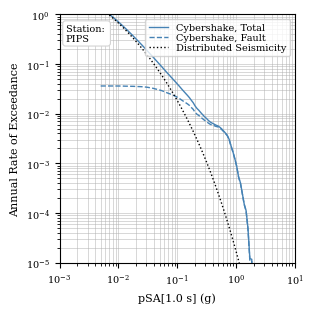

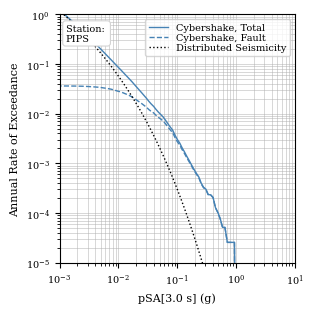

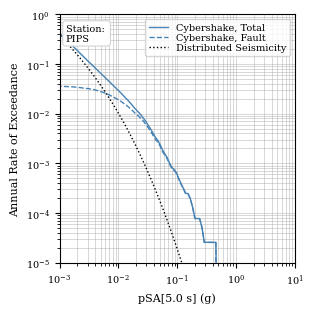

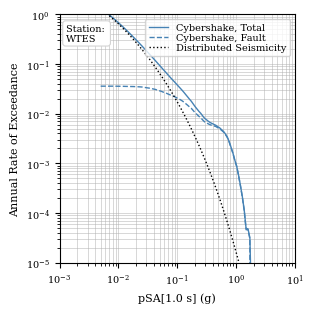

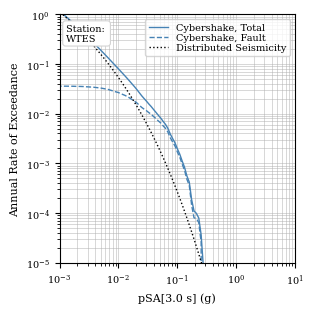

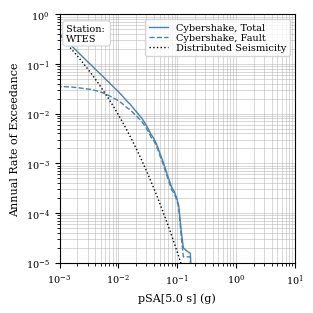

In [17]:
for st in stations:
    for im in ims:
        im_str = convert_im(im)
        fig, ax = plt.subplots(figsize=(8 / 2.54, 8 / 2.54))

        # CS Plot
        if csds_flag == 1:
            ax.plot(
                csds_im_hz_dic[im].loc[st].index.values,
                csds_im_hz_dic[im].loc[st].values,
                color=color_dic["csds_color"],
                linestyle=linestyle_dic["csds_linestyle"],
                linewidth=linewidth_dic["csds_linewidth"],
                label="Cybershake, Total",
            )

        # CS Plot
        if fltds_flag == 1:
            ax.plot(
                cs_im_hz_dic[im].loc[st].index.values,
                cs_im_hz_dic[im].loc[st].values,
                color=color_dic["cs_color"],
                linestyle=linestyle_dic["cs_linestyle"],
                linewidth=linewidth_dic["cs_linewidth"],
                label="Empirical, Total",
            )

        # CS Plot
        if cs_flag == 1:
            ax.plot(
                cs_im_hz_dic[im].loc[st].index.values,
                cs_im_hz_dic[im].loc[st].values,
                color=color_dic["cs_color"],
                linestyle=linestyle_dic["cs_linestyle"],
                linewidth=linewidth_dic["cs_linewidth"],
                label="Cybershake, Fault",
            )

        # FLT Plot
        if flt_flag == 1:
            ax.plot(
                cs_im_hz_dic[im].loc[st].index.values,
                cs_im_hz_dic[im].loc[st].values,
                color=color_dic["cs_color"],
                linestyle=linestyle_dic["cs_linestyle"],
                linewidth=linewidth_dic["cs_linewidth"],
                label="Empirical, Fault",
            )

        # DS Plot
        if ds_flag == 1:
            ax.plot(
                ds_im_hz_dic[im].loc[st].index.values,
                ds_im_hz_dic[im].loc[st].values,
                color=color_dic["ds_color"],
                linestyle=linestyle_dic["ds_linestyle"],
                linewidth=linewidth_dic["ds_linewidth"],
                label="Distributed Seismicity",
            )

        fig.text(
            0.21,
            0.92,
            f"Station: \n{st}",
            ha="left",
            va="top",
            fontsize=7,
            wrap=True,
            bbox=dict(
                facecolor="white",  # Background color
                edgecolor="lightgrey",  # Border color
                boxstyle="round,pad=0.3",  # Rounded box with padding
                linewidth=0.8,  # Thickness of the border
            ),
        )

        ax.set_xlim([1e-3, 1e1])
        ax.set_ylim([1e-5, 1e0])
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.7)
        # ax.set_title(f"{im}")
        ax.set_xlabel(im_str)
        ax.set_ylabel("Annual Rate of Exceedance")
        ax.legend(loc="upper right", labelspacing=0.1)
        plt.tight_layout()
        plt.show()

## Uniform Hazard Spectrum in Specific Station(s)

## Uniform Hazard Map of Specific IM(s)

In [ ]:
# Check if the directory exists
if Path(hzrd_dir).exists():
    shutil.rmtree(hzrd_dir)
    print(f"Deleted and renewed the path: \n{hzrd_dir}")
    os.makedirs(hzrd_dir, exist_ok=False)
else:
    os.makedirs(hzrd_dir, exist_ok=False)
    print(f"Created the path: \n{hzrd_dir}")
    
file_name = "IM_Hazard_Dic.pkl"
file_path = os.path.join(hzrd_dir, file_name)

# Save the dictionary
with open(file_path, "wb") as file:
    pickle.dump(im_hazard_dic, file)

print(f"Dictionary saved to {file_path}")

In [ ]:
print(im_hazard_dic["pSA_0.12"].columns)

In [ ]:

# Load ERF & IM data
flt_erf_df = nhm.load_nhm_df(str(fault_erf_ffp))
fault_im_data = sha.nshm_2010.load_sim_im_data(im_dir)

# Compute site hazard
site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_data, "PIPS")
im_hazard = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df)



In [ ]:
# Plot
im = "pSA_1.0"
fig = plt.figure(figsize=(16, 10))

plt.plot(
    im_hazard_dic["pSA_0.12"].loc["PIPS"].index.values,
    im_hazard_dic["pSA_0.12"].loc["PIPS"].values,
)
plt.xlabel(f"{im}")
plt.ylabel("Annual Exceedance Probability")

plt.xscale("log")
plt.yscale("log")

fig.tight_layout()
plt.show()

# Placeholder


In [ ]:
im_true_order = [
    "PGA",
    "PGV",
    "CAV",
    "AI",
    "Ds575",
    "Ds595",
    "MMI",
    "pSA_0.01",
    "pSA_0.02",
    "pSA_0.03",
    "pSA_0.04",
    "pSA_0.05",
    "pSA_0.075",
    "pSA_0.1",
    "pSA_0.12",
    "pSA_0.15",
    "pSA_0.17",
    "pSA_0.2",
    "pSA_0.25",
    "pSA_0.3",
    "pSA_0.4",
    "pSA_0.5",
    "pSA_0.6",
    "pSA_0.7",
    "pSA_0.75",
    "pSA_0.8",
    "pSA_0.9",
    "pSA_1.0",
    "pSA_1.25",
    "pSA_1.5",
    "pSA_2.0",
    "pSA_2.5",
    "pSA_3.0",
    "pSA_4.0",
    "pSA_5.0",
    "pSA_6.0",
    "pSA_7.5",
    "pSA_10.0",
]

im_hazard_dic = {
    im: pd.DataFrame(
        index=stations_df["station_name"],
        columns=sha.utils.get_im_levels(im).tolist(),
    )
    for im in im_true_order
}


def process_station(st, ims):
    Station_Name = st
    site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_data, Station_Name)
    im_hazard = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df, ims)

    for im, value in im_hazard.items():
        valid_columns = im_hazard_dic[im].columns.intersection(value.index)
        im_hazard_dic[im].loc[Station_Name, valid_columns] = value[valid_columns].values


# List of stations to process
# stations = ["PIPS"]
stations = stations_df["station_name"].to_list()

with ThreadPoolExecutor() as executor:
    executor.map(process_station, stations)


# for st in ["PIPS"]: #stations_df.itertuples():
#     Station_Name = st#.station_name
#     site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_data, Station_Name)
#     im_hazard = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df)

#     for im, value in im_hazard.items():
#         valid_columns = im_hazard_dic[im].columns.intersection(value.index)
#         im_hazard_dic[im].loc[Station_Name, valid_columns] = value[valid_columns].values

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

im_true_order = [
    "PGA",
    "PGV",
    "CAV",
    "AI",
    "Ds575",
    "Ds595",
    "MMI",
    "pSA_0.01",
    "pSA_0.02",
    "pSA_0.03",
    "pSA_0.04",
    "pSA_0.05",
    "pSA_0.075",
    "pSA_0.1",
    "pSA_0.12",
    "pSA_0.15",
    "pSA_0.17",
    "pSA_0.2",
    "pSA_0.25",
    "pSA_0.3",
    "pSA_0.4",
    "pSA_0.5",
    "pSA_0.6",
    "pSA_0.7",
    "pSA_0.75",
    "pSA_0.8",
    "pSA_0.9",
    "pSA_1.0",
    "pSA_1.25",
    "pSA_1.5",
    "pSA_2.0",
    "pSA_2.5",
    "pSA_3.0",
    "pSA_4.0",
    "pSA_5.0",
    "pSA_6.0",
    "pSA_7.5",
    "pSA_10.0",
]

im_hazard_dic = {
    im: pd.DataFrame(
        index=stations_df["station_name"],
        columns=sha.utils.get_im_levels(im).tolist(),
    )
    for im in im_true_order
}

def process_station(st):
    Station_Name = st
    site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_data, Station_Name)
    im_hazard = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df, im_true_order)

    for im, value in im_hazard.items():
        valid_columns = im_hazard_dic[im].columns.intersection(value.index)
        im_hazard_dic[im].loc[Station_Name, valid_columns] = value[valid_columns].values


batch_size = 100
stations = stations_df["station_name"].to_list()
station_batches = [
    stations[i : i + batch_size] for i in range(0, len(stations), batch_size)
]
stations = station_batches[0]

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_station, st): st for st in stations}
    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing Stations"
    ):
        try:
            future.result() 
        except Exception as e:
            print(f"Error processing station {futures[future]}: {e}")

In [ ]:
batch_size = 10
stations = stations_df["station_name"].to_list()
station_batches = [
    stations[i : i + batch_size] for i in range(0, len(stations), batch_size)
]

In [ ]:
station_batches[0]

In [ ]:
flt_erf_df

In [ ]:
simulated_faults=sorted(list(fault_im_data.keys()))

In [ ]:
temp_df=flt_erf_df.loc[simulated_faults]
temp_df.pivot_table(index="tectonic_type", aggfunc="size", margins=False).reset_index(
    name="Count"
)

In [ ]:
temp_df